# Анализ данных, заполнение и модификация

Ссылка на презентацию

https://docs.google.com/presentation/d/1i1YYzqoq1IsIbBy5NkHoPCJ7OS5yaM2uNcri7-QRB6E/edit?usp=sharing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import scipy
# !pip3 install pyproj
import pyproj
import gc

## Вспомогательные функции

In [2]:
def geo_distance(lat1, long1, lat2, long2):
    '''Функция для получения расстояния между станциями
    lat1 - широта первой точки
    long1 - долгота первой точки
    lat2 - широта второй точки
    long2 - долгота второй точки
    return dist, angl1, angl2 - расстояние между точками, уголы между точками
    '''
    geod = pyproj.Geod(ellps="WGS84")
    angle1, angle2, distance = geod.inv(long1, lat1, long2, lat2)
    if angle1 < 0: angle1 = 360 + angle1
    if angle2 < 0: angle2 = 360 + angle2
    return angle1, angle2, distance

In [3]:
data_type = {'lac':np.int, 'cid': np.int, 'msisdn':np.int, 'imei':str,
             'event_type':np.int, 'tstamp':np.int, 'long':np.float, 'lat':np.float,
             'max_dist':np.int, 'cell_type':str, 'start_angle':np.float, 'end_angle':np.float}

In [4]:
data = pd.read_csv('data.csv', sep=';', dtype=data_type)
device = pd.read_csv('device.csv', sep=',')
# event = pd.read_excel('event.xlsx')

Добавляем данные об устройствах

In [5]:
print(data.shape)
data['tac'] = data.imei.apply(lambda r: r[:8] if isinstance(r,str) else r)
data['tac'] = data['tac'].fillna(0)
data['tac'] = data['tac'].astype(int)
data = data.merge(device, how='left', on='tac')
data.drop('tac', axis=1, inplace=True)
print(data.shape)
del device
gc.collect()

(174123, 12)
(174123, 15)


0

Анализ устройств в разрезе событий, которые они генерируют

In [6]:
data.event_type.value_counts()

0     77847
10    22237
8     16950
2     16807
5     15752
3     14873
1      8950
7       462
9       239
6         6
Name: event_type, dtype: int64

In [7]:
all_events = set([i for i in range(11)])

In [8]:
event_by_type = data[data.vendor!='FAKE'].groupby('type').event_type.agg(list)
event_by_type = event_by_type.apply(set)
event_by_type

type
Data card                  {0, 1, 2, 3, 5, 8, 10}
Laptop               {0, 1, 2, 3, 5, 7, 8, 9, 10}
Network device             {0, 1, 2, 3, 5, 8, 10}
Phone             {0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
SmartPhone           {0, 1, 2, 3, 5, 7, 8, 9, 10}
USB modem                  {0, 1, 2, 3, 5, 8, 10}
Name: event_type, dtype: object

In [9]:
'''Видим что SmartPhone и Laptop, можно отличить от Phone по событию 6
А Data card, Network device и USB modem от всех остальных по событиям 7, 9, но они довольно редкие'''
not_event_by_type = event_by_type.apply(lambda r: all_events.difference(r))
not_event_by_type

type
Data card         {9, 4, 6, 7}
Laptop                  {4, 6}
Network device    {9, 4, 6, 7}
Phone                      {4}
SmartPhone              {4, 6}
USB modem         {9, 4, 6, 7}
Name: event_type, dtype: object

In [10]:
data.cell_type.value_counts()

OUTDOOR    169912
INDOOR       2184
METRO        2027
Name: cell_type, dtype: int64

In [11]:
'''Также можно отсечь USB modem и Network device по cell_type!=METRO'''
cell_type_by_type = data[data.vendor!='FAKE'].groupby('type').cell_type.agg(list)
cell_type_by_type = cell_type_by_type.apply(set)
cell_type_by_type

type
Data card         {OUTDOOR, INDOOR, METRO}
Laptop            {OUTDOOR, INDOOR, METRO}
Network device           {OUTDOOR, INDOOR}
Phone             {OUTDOOR, INDOOR, METRO}
SmartPhone        {OUTDOOR, INDOOR, METRO}
USB modem                {OUTDOOR, INDOOR}
Name: cell_type, dtype: object

In [12]:
event_by_vendor = data[data.vendor!='FAKE'].groupby('vendor').event_type.agg(list)
event_by_vendor = event_by_vendor.apply(set)
event_by_vendor

vendor
Acer                           {0, 1, 5}
Alcatel           {0, 1, 2, 3, 5, 8, 10}
Aole              {0, 1, 2, 3, 5, 8, 10}
Apple       {0, 1, 2, 3, 5, 7, 8, 9, 10}
Asus              {0, 1, 2, 3, 5, 8, 10}
                        ...             
Umeox             {0, 1, 2, 3, 5, 8, 10}
Vertu                {0, 1, 2, 3, 8, 10}
Wavecom                    {1, 2, 10, 5}
Xtelecom             {0, 1, 2, 3, 8, 10}
ZTE         {0, 1, 2, 3, 5, 7, 8, 9, 10}
Name: event_type, Length: 68, dtype: object

In [13]:
not_event_by_vendor = event_by_vendor.apply(lambda r: all_events.difference(r))
not_event_by_vendor

vendor
Acer        {2, 3, 4, 6, 7, 8, 9, 10}
Alcatel                  {9, 4, 6, 7}
Aole                     {9, 4, 6, 7}
Apple                          {4, 6}
Asus                     {9, 4, 6, 7}
                      ...            
Umeox                    {9, 4, 6, 7}
Vertu                 {4, 5, 6, 7, 9}
Wavecom         {0, 3, 4, 6, 7, 8, 9}
Xtelecom              {4, 5, 6, 7, 9}
ZTE                            {4, 6}
Name: event_type, Length: 68, dtype: object

In [14]:
event_by_platform = data[data.vendor!='FAKE'].groupby('platform').event_type.agg(list)
event_by_platform = event_by_platform.apply(set)
event_by_platform

platform
Android              {0, 1, 2, 3, 5, 7, 8, 9, 10}
Bada OS              {0, 1, 2, 3, 5, 7, 8, 9, 10}
BlackBerry OS           {0, 1, 2, 3, 5, 7, 8, 10}
ISA               {0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
Maemo                      {0, 1, 2, 3, 7, 8, 10}
MeeGo                            {0, 2, 5, 8, 10}
Nucleus OS                    {0, 1, 2, 3, 8, 10}
Proprietary       {0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
Symbian OS           {0, 1, 2, 3, 5, 7, 8, 9, 10}
Windows Mobile       {0, 1, 2, 3, 5, 7, 8, 9, 10}
Windows Phone        {0, 1, 2, 3, 5, 7, 8, 9, 10}
iOS                  {0, 1, 2, 3, 5, 7, 8, 9, 10}
uC-OS/II                         {0, 2, 3, 8, 10}
Name: event_type, dtype: object

In [15]:
not_event_by_platform = event_by_platform.apply(lambda r: all_events.difference(r))
not_event_by_platform

platform
Android                       {4, 6}
Bada OS                       {4, 6}
BlackBerry OS              {9, 4, 6}
ISA                              {4}
Maemo                   {9, 4, 5, 6}
MeeGo             {1, 3, 4, 6, 7, 9}
Nucleus OS           {4, 5, 6, 7, 9}
Proprietary                      {4}
Symbian OS                    {4, 6}
Windows Mobile                {4, 6}
Windows Phone                 {4, 6}
iOS                           {4, 6}
uC-OS/II          {1, 4, 5, 6, 7, 9}
Name: event_type, dtype: object

На основе вышеизложенных данных можно сузить диапазон вариантов для определения устройств без imei

## Анализируем верные ответы

In [16]:
facts = pd.read_excel('facts.xlsx',names=['first', 'second'])

In [17]:
def data_exist(val):
    '''Смотрит, существуют ли для данной симки, записи в файле data
    val - номер симки
    return - val/Nan - либо номер симки, если она есть, либо Nan, если ее нет'''
    if data[data.msisdn==val].shape[0] == 0:
        return np.nan
    return val

facts['first'] = facts['first'].apply(data_exist)
facts['second'] = facts['second'].apply(data_exist)
facts.dropna(inplace=True)
facts['first'] = facts['first'].astype(int)
facts['second'] = facts['second'].astype(int)

In [18]:
first_device, second_device = [], []
for first, second in facts.values:
    first_device.append(data[data.msisdn==first].drop_duplicates(['msisdn', 'type']).type.values)
    second_device.append(data[data.msisdn==second].drop_duplicates(['msisdn', 'type']).type.values)
facts['first_device'] = first_device
facts['second_device'] = second_device
def device_equal(first, second):
    '''Проверяет совпадает ли хоть одно устройство первой симки с любым устройством второй симки
    first - набор устройств первой симки
    second - набор устройств второй симки
    return - True/False'''
    if set(first) == set(second): return True
    for val in first:
        if val in second: return True
    return False
facts['equal'] = facts.apply(lambda r: device_equal(r[2], r[3]),axis=1)

In [19]:
all_device_1 = []
for i in facts.first_device.value_counts().index:
    all_device_1.extend(i)
all_device_1 = set(all_device_1)

all_device_2 = []
for i in facts.second_device.value_counts().index:
    all_device_2.extend(i)
all_device_2 = set(all_device_2)

In [20]:
all_device_1, all_device_2

({'Laptop', 'Phone', 'SmartPhone', 'USB modem', nan},
 {'Data card', 'Laptop', 'Phone', 'SmartPhone', 'USB modem', nan})

In [21]:
facts.first_device.value_counts()[:5]

[Phone]                61
[SmartPhone]           18
[Laptop]                7
[USB modem]             2
[SmartPhone, Phone]     1
Name: first_device, dtype: int64

In [22]:
facts.second_device.value_counts()[:5]

[Phone]                55
[SmartPhone]           28
[USB modem]             5
[Laptop]                2
[Phone, SmartPhone]     1
Name: second_device, dtype: int64

In [23]:
'''Распределение совпадений и не совпадений устройств'''
facts.equal.value_counts()

True     63
False    56
Name: equal, dtype: int64

## Работаем с data

Анализ imei для которых нет записей в device и симок, у которых нет imei

In [24]:
def fill_device_type(event_set, cell_type_set):
    '''Функция, которая пытается заполнить пропуки в типах устройств
    Первые два условия, дают хорошую точность, но малое покрытие
    Третье условие, очень спорное, но решил попробовать
    event_set - набор уникальных событий для устройства
    cell_type_set - набор уникальных cell_type для устройства
    return - device_type (создаются некие агрегированные типы устройств)'''
    if 6 in event_set: return 'Phone'
    if 7 in event_set or 9 in event_set: return 'Smart_Lap_Phone'
    if 'METRO' not in cell_type_set: return 'USB_Network'
    return np.nan

In [25]:
'''Собираем события и cell_type по imei, которые не имеют описания device
Пытаемся заполнить пробелы в типе устройства, где это возможно'''
no_device_imei_event = data[data.type.isna()].groupby('imei')\
                            .event_type.agg(list).apply(lambda r: set(r)).to_frame().reset_index()
no_device_imei_cell_type = data[data.type.isna()].groupby('imei')\
                            .cell_type.agg(list).apply(lambda r: set(r)).to_frame().reset_index()
no_device_imei = no_device_imei_event.merge(no_device_imei_cell_type, on='imei')
no_device_imei['device'] = no_device_imei.apply(lambda r: fill_device_type(r[1], r[2]), axis=1)
no_device_imei.device.value_counts()

USB_Network        130
Smart_Lap_Phone     20
Name: device, dtype: int64

In [26]:
'''создаем словарь для заполнения типов устройств и применяем его'''
imei2device = {key:val for key, val in no_device_imei[['imei', 'device']].values}
data.loc[data.type.isna(), 'type'] = data.loc[data.type.isna(), 'imei'].map(imei2device)
del no_device_imei, imei2device
gc.collect()

0

In [27]:
'''Собираем события и cell_type по msisdn, которые не имеют imei
Пытаемся заполнить пробелы в типе устройства, где это возможно'''
no_imei_event = data[data.imei.isna()].groupby('msisdn')\
                        .event_type.agg(list).apply(lambda r: set(r)).to_frame().reset_index()
no_imei_cell_type = data[data.imei.isna()].groupby('msisdn')\
                        .cell_type.agg(list).apply(lambda r: set(r)).to_frame().reset_index()
no_imei = no_imei_event.merge(no_imei_cell_type, on='msisdn')
no_imei['device'] = no_imei.apply(lambda r: fill_device_type(r[1], r[2]), axis=1)
no_imei.device.value_counts()

USB_Network    816
Name: device, dtype: int64

In [28]:
'''создаем словарь для заполнения типов устройств и применяем его'''
msisdn2device = {key:val for key, val in no_imei[['msisdn', 'device']].values}
data.loc[data.imei.isna(), 'type'] = data.loc[data.imei.isna(), 'msisdn'].map(msisdn2device)
del no_imei, msisdn2device
gc.collect()

0

### Делаем некоторые преобразования с data

In [29]:
'''преобразуем данные в формат даты/времени'''
data.tstamp = data.tstamp/1000
data.tstamp = data.tstamp.apply(datetime.datetime.utcfromtimestamp)
'''получаем имя дня недели'''
data['day_of_week'] = data.tstamp.dt.day_name()
'''получаем день месяца'''
data['day_of_month'] = data.tstamp.dt.day
'''получаем время в минутах, в пределах одного дня''' 
data['minutes'] = data.tstamp.dt.hour * 60 + data.tstamp.dt.minute
'''делим сутки на день и ночь (возможно тут стоит еще поэкспериментировать с временными границами
и количеством делений дня на части)''' 
data['work_day'] = (data.tstamp.dt.hour > 8) & (data.tstamp.dt.hour < 20)
data['night'] = (data.tstamp.dt.hour <= 8) | (data.tstamp.dt.hour >= 20)
data.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle,vendor,platform,type,day_of_week,day_of_month,minutes,work_day,night
0,5029,40798,158529599791,353111050313790,0,2013-05-22 20:00:00.974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0,LG,Android,SmartPhone,Wednesday,22,1200,False,True
1,7782,56870,158520145943,012929002676510,5,2013-05-22 20:00:01.396,37.4239,55.7426,2,OUTDOOR,45.0,105.0,Apple,iOS,Laptop,Wednesday,22,1200,False,True
2,7794,32226,158521798391,351994049226010,5,2013-05-22 20:00:02.013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0,Nokia,ISA,Phone,Wednesday,22,1200,False,True
3,7758,33528,158537830573,358627016731770,0,2013-05-22 20:00:02.331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0,Nokia,ISA,Phone,Wednesday,22,1200,False,True
4,5060,17568,158510204039,352458051767250,8,2013-05-22 20:00:03.586,37.1900,55.8308,500,OUTDOOR,180.0,240.0,Samsung,Proprietary,Phone,Wednesday,22,1200,False,True


In [30]:
print(data[data.day_of_month==22].drop_duplicates('msisdn').shape)
print(data[data.day_of_month==23].drop_duplicates('msisdn').shape)
print(data[data.day_of_month==24].drop_duplicates('msisdn').shape)
print(data[data.day_of_month==25].drop_duplicates('msisdn').shape)
print(data[data.day_of_month==28].drop_duplicates('msisdn').shape)
print(data[data.day_of_month==29].drop_duplicates('msisdn').shape)
print(data[data.day_of_month==30].drop_duplicates('msisdn').shape)

(866, 20)
(2235, 20)
(2247, 20)
(2144, 20)
(2, 20)
(2, 20)
(2, 20)


In [31]:
'''Оставляем данные по трем дням, по которым есть данные почти по всем симкам
22-й день имеет малую чать записей и только на конец дня, 28-30 имеют записи лишь по 2 симкам
'''

data = data[data.day_of_month.isin([23,24,25])]

Применяем кодирование категориальных признаков и удаляем столбцы, которые не планируем использовать

In [32]:
data = pd.concat([data, pd.get_dummies(data.cell_type),
                        pd.get_dummies(data.event_type, prefix='event'),
                        pd.get_dummies(data.type),],
                 axis=1)
data.drop(['vendor', 'cell_type', 'event_type', 'platform', 'type'], axis=1, inplace=True)

### Строим вектора для симок

In [33]:
def make_cat_vector(df):
    '''Создает категориальную часть вектора признаков + некоторые дополнительные признаки,
    ск оторыми так же как и с категориальными не будет производится математических операций
    при формировании совместного вектора для двух симок
    df - исходный набор данных
    return - new_df - трансформированный набор данных'''
    new_df = df.groupby('msisdn').agg(sum).loc[:,'INDOOR':'USB_Network']
    new_df.loc[:,'Data card':'USB_Network'] = new_df.loc[:, 'Data card':'USB_Network']/new_df.loc[:,'Data card':'USB_Network']
    new_df = new_df.fillna(0)
    new_df['num_imei'] = df.drop_duplicates(['msisdn', 'imei']).groupby('msisdn').imei.agg(list).apply(lambda r: len(r))
    new_df['num_event'] = new_df[[c for c in new_df.columns if c.startswith('event_')]].sum(axis=1).astype(int)
    new_df['mean_event'] = new_df['num_event']/df.day_of_month.nunique()
    new_df['num_lac'] = df.drop_duplicates(['msisdn', 'lac']).groupby('msisdn').lac.agg(list).apply(lambda r: len(r))
    new_df['num_cid'] = df.drop_duplicates(['msisdn', 'cid']).groupby('msisdn').cid.agg(list).apply(lambda r: len(r))
    new_df['mean_lac'] = new_df['num_lac']/df.day_of_month.nunique()
    new_df['mean_cid'] = new_df['num_cid']/df.day_of_month.nunique()
    return new_df

Набор "категориальной" части векторов

In [34]:
df_cat_vectors = make_cat_vector(data)
df_cat_vectors.head()

,INDOOR,METRO,OUTDOOR,event_0,event_1,event_2,event_3,event_5,event_6,event_7,...,Smart_Lap_Phone,USB modem,USB_Network,num_imei,num_event,mean_event,num_lac,num_cid,mean_lac,mean_cid
msisdn,,,,,,,,,,,,,,,,,,,,,
158500002513,0.0,0.0,8.0,0.0,2.0,1.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1,8,2.666667,1,2,0.333333,0.666667
158500006927,0.0,0.0,141.0,14.0,18.0,14.0,8.0,56.0,0.0,1.0,...,0.0,0.0,1.0,3,141,47.000000,10,53,3.333333,17.666667
158500010757,12.0,0.0,97.0,14.0,9.0,21.0,4.0,22.0,0.0,0.0,...,0.0,0.0,1.0,2,109,36.333333,9,46,3.000000,15.333333
158500013119,1.0,0.0,127.0,73.0,3.0,18.0,9.0,0.0,0.0,3.0,...,0.0,0.0,1.0,2,128,42.666667,19,80,6.333333,26.666667
158500019021,0.0,0.0,32.0,10.0,0.0,7.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1,32,10.666667,5,25,1.666667,8.333333


Проверяем, что не потеряли данные

In [35]:
data.msisdn.nunique(), df_cat_vectors.shape

(2358, (2358, 28))

Строим вектора передвижений абонента во времени

In [83]:
def get_nearest(vector1, vector2):
    '''Возвращает косинусное расстояние между векторами
    vector1 - первый вектор
    vector2 - второй вектор
    return - dist - косинусное расстояние
    '''
    return scipy.spatial.distance.cosine(vector1, vector2)

def make_vector(df, index, column, values):
    '''Собирает записи по каждой симке в единый вектор
    df - исходный набор данных
    index - имя колонки, которая станет индексом
    column - имя колонки, значения которой станут столбцами
    values - имена колонок, данные из которых заполнят таблицу
    return vectors_df - модифицированный набор данных
    '''
    vectors_df = df.copy()
    vectors_df.drop_duplicates([index, column], inplace=True)
    vectors_df = vectors_df.pivot(index=index, columns=column, values=values)#.fillna(axis=1, method='ffill').dropna(axis=1)
    return vectors_df

def make_day_vectors(df, day, step=60):
    '''Разбивает данные за день по каждой симке на равные диапазоны с заданным шагом,
    чтобы затем получить равные временные вектора по всем симкам
    df - исходный набор данных
    day - день, по которому фильтровать
    step - шаг (в минутах) с которым строить временной вектор
    return - day_df - преобразованный набор данных за выбранный день'''
    day_df = df[df.day_of_month==day][['msisdn', 'long', 'lat', 'minutes']].copy()
    day_df['point'] = -1
    for i, start in enumerate(range(0, 24 * 60 + 1, step)):
        day_df.loc[(day_df.minutes >= start) & (day_df.minutes < start + step), 'point'] = i 
    day_df.drop('minutes', axis=1, inplace=True)
    day_df = make_vector(day_df, 'msisdn', 'point', ['long', 'lat'])
    return day_df

def make_dfs(df, days, step=60):
    '''Создает словарь с преобразованными наборами данных за выбранные дни.
    К тому же, разбивает их на день и ночь
    df - исходный набор данных
    days - дни, по которым строить словарь
    step - шаг, который бьет день на равное для всех симок количество временных отрезков
    return - dfs - словарь, содержащий количество дней*2 значений (за каждый день: ночь и день)'''
    df_day = df[df.work_day==1].copy()
    df_night = df[df.night==1].copy()
    dfs = {}
    for day in days:
        dfs['day_{}'.format(day)] = make_day_vectors(df_day, day, step)
        dfs['night_{}'.format(day)] = make_day_vectors(df_night, day, step)
    return dfs

def merge_dist_vectors(dfs, sims1, sims2, train_mode=True):
    '''Находит расстояние между двумя векторами и складывает их в новый набор данных
    sims1 - номера первых симок в паре
    sims2 - номера вторых симок в паре
    dfs - наборы данных с векторами по каждой симке
    train_mode - тренировочный или тестовый режим
    return - df с новыми векторами, образованными из двух входящих векторов за каждый день и каждую ночь'''
    vectors_dict = {}
    for sim1, sim2 in zip(sims1, sims2):
        feature_list = []
        for name, df in dfs.items():
            df2vec1 = df[df.index.isin([sim1, sim2])]
            df2vec2 = df2vec1.dropna(axis=1)

            if df2vec2.shape[0] < 2:
                feature_list.extend([np.nan, np.nan, np.nan])
                continue
            if df2vec2.shape[1] < 2:
                df2vec1 = df2vec1.fillna(0)
                feature_list.extend([0, df2vec1.shape[1], get_nearest(df2vec1.values[0],df2vec1.values[1])])
                continue
            feature_list.extend([1, df2vec2.shape[1], get_nearest(df2vec2.values[0],df2vec2.values[1])])
        if train_mode:
            vectors_dict['{}_{}'.format(sim1, sim2)] = np.array(feature_list)
            vectors_dict['{}_{}'.format(sim2, sim1)] = np.array(feature_list)
        else:
            vectors_dict['{}_{}'.format(sim1, sim2)] = np.array(feature_list)
    return pd.DataFrame(vectors_dict).T.fillna(-1)
        
def merge_cat_vectors(df, sims1, sims2, labs, train_mode=True):
    '''Формируем набор данных с векторами методом конкатенации двух отдельных векторов
    df - 
    sims1 - номера первых симок в паре
    sims2 - номера вторых симок в паре
    labs - метки классов
    train_mode - тренировочный или тестовый режим
    return - df - набор данных из парных векторов'''
    vectors_dict = {}
    for sim1, sim2, lab in zip(sims1, sims2, labs):
        if train_mode:
            vectors_dict['{}_{}'.format(sim1, sim2)] = np.concatenate((df[df.index==sim1].values,
                                                                       df[df.index==sim2].values,
                                                                       np.array([[lab]])
                                                                      ),
                                                                      axis=1).ravel()
            vectors_dict['{}_{}'.format(sim2, sim1)] = np.concatenate((df[df.index==sim2].values,
                                                                       df[df.index==sim1].values,
                                                                       np.array([[lab]])
                                                                      ),
                                                                      axis=1).ravel()
        else:
            vectors_dict['{}_{}'.format(sim1, sim2)] = np.concatenate((df[df.index==sim1].values,
                                                                       df[df.index==sim2].values
                                                                      ),
                                                                      axis=1).ravel()
    return pd.DataFrame(vectors_dict).T

Словарь с наборами данных по всем дням и ночам с векторами перемещения во времени

In [37]:
dfs = make_dfs(data, [23,24,25], 60)
dfs.keys()

dict_keys(['day_23', 'night_23', 'day_24', 'night_24', 'day_25', 'night_25'])

## Формируем обучающий набор

Проверяем, чтобы все симки, которые в учебном наборе, были  в нашем рабочем наборе данных

In [38]:
facts = facts[['first', 'second']]
facts['first'] = facts['first'].apply(data_exist)
facts['second'] = facts['second'].apply(data_exist)
facts.dropna(inplace=True)
facts['first'] = facts['first'].astype(int)
facts['second'] = facts['second'].astype(int)
facts.shape

(118, 2)

In [39]:
def train_sims(df, datas):
    '''Формирует обучащий набор данных
    df - набор данных с правильными ответами
    datas - набор всех рабочих векторов
    return - sims1, sims2, labs - вектора симок и метки соответствующие их парам'''
    sims1, sims2, labs = [], [], []
    for sim1, sim2 in df.values:
        sims1.append(sim1)
        sims2.append(sim2)
        labs.append(1)
    new_df = pd.DataFrame()
    new_df['1'] = df['first'].copy()
    new_df['2'] = np.array(df['second'].to_list()[::-1]).reshape((-1,1))
    new_df['3'] = datas[~datas.index.isin(df['first'].values)
                        & ~datas.index.isin(df['second'].values)]\
                        .sample(df.shape[0]).index
    for sim1, sim2, sim3 in new_df.values:
        sims1.append(sim1)
        sims2.append(sim2)
        sims1.append(sim1)
        sims2.append(sim3)
        labs.append(0)
        labs.append(0)
    return sims1, sims2, labs

Готовим пары симок

In [40]:
sims1, sims2, labs = train_sims(facts, df_cat_vectors)
len(sims1), len(sims2), len(labs)

(354, 354, 354)

Готовим парные "категориальные" вектора

In [84]:
X_cat = merge_cat_vectors(df_cat_vectors, sims1, sims2, labs)

Готовим вектора из пар векторов, которые представляют из себя координаты во времени

In [85]:
X_dist = merge_dist_vectors(dfs, sims1, sims2)

Собираем все вместе

In [50]:
X = X_dist.merge(X_cat, left_index=True, right_index=True)
y = X.iloc[:, -1].astype(int).values
X = X.iloc[:, :-1].values

In [51]:
X.shape, y.shape

((708, 74), (708,))

## Переходим к обучению модели

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [68]:
def pred(x_train, x_test, y_train, y_test, verbose=False):
     
    param_grid = {
    "n_estimators": [100, 200, 300, 400,500],
    "criterion": ['entropy'],
    "min_samples_split": [2, 3, 5, ],
    "max_depth": [25,50,75,None, ],
    "min_samples_leaf":[2, 3, 5, ],
    "verbose":[1, 2, 3, ]
    }
    
    rf = GridSearchCV(RandomForestClassifier(class_weight='balanced',
                                             random_state = 42, n_jobs=-1)
                      ,param_grid, n_jobs=-1, cv=5)
#     rf = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=5, min_samples_split=2,
#                                 n_estimators=200, verbose=1, random_state = 42, n_jobs=12, class_weight='balanced')
    rf.fit(x_train, y_train)
    predict = rf.predict(x_test)
    best_params = rf.best_params_
    print(rf.best_params_)
    print('ROC-AUC score: ', metrics.roc_auc_score(y_test, predict))
    print(metrics.classification_report(y_test, predict))
    print(metrics.confusion_matrix(y_test, predict))

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, rf.predict_proba(x_test)[:,1], pos_label=1)
    
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()
    return best_params

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500, 'verbose': 1}
ROC-AUC score:  0.7870124566060854
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        83
           1       0.92      0.61      0.73        59

    accuracy                           0.82       142
   macro avg       0.85      0.79      0.80       142
weighted avg       0.84      0.82      0.81       142

[[80  3]
 [23 36]]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


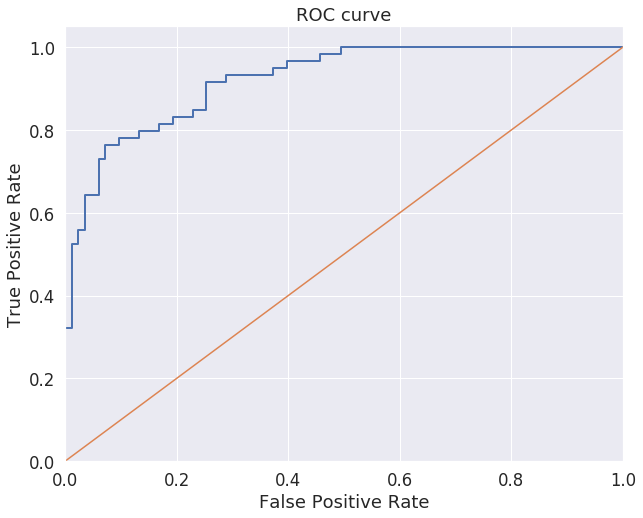

In [69]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_params = pred(x_train, x_test, y_train, y_test, True)

In [70]:
{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500, 'verbose': 1}

{'criterion': 'entropy',
 'max_depth': 25,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500,
 'verbose': 1}

Обучаем алгоритм на всех данных и с лучшими параметрами

In [71]:
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.4s finished


In [72]:
import pickle
with open('search_couples.pickle', 'wb') as handle:
    pickle.dump(rf_clf, handle, protocol=2, )

## Тестируем

In [87]:
without_facts = data[~data.msisdn.isin(facts['first'].values) & ~data.msisdn.isin(facts['second'].values)]
without_facts = without_facts[(without_facts['Phone']==1)|(without_facts['SmartPhone']==1)| (without_facts['Laptop']==1)]
without_facts = without_facts.msisdn.unique()

In [165]:
sims1, sims2 = [], []
i = 211

for i in range(i, len(without_facts)):
    for j in range(i+1, len(without_facts)):
        if without_facts[i] != without_facts[j]:
            sims1.append(without_facts[i])
            sims2.append(without_facts[j])
    i+=1
    if i>121:
        break
len(sims1), len(sims2)

(89658, 89658)

In [166]:
%%time
X_cat_test = merge_cat_vectors(df_cat_vectors, sims1, sims2, np.zeros(len(sims1)), False)

CPU times: user 2min 12s, sys: 270 ms, total: 2min 13s
Wall time: 2min 13s


In [167]:
%%time
X_dist_test = merge_dist_vectors(dfs, sims1, sims2, False)

CPU times: user 27min 5s, sys: 631 ms, total: 27min 5s
Wall time: 27min 5s


In [168]:
%%time
X = X_dist_test.merge(X_cat_test, left_index=True, right_index=True)

CPU times: user 149 ms, sys: 668 ms, total: 817 ms
Wall time: 2.8 s


In [169]:
predict = rf_clf.predict_proba(X)
X['predict'] = predict[:,1]
X['predict'] = X['predict'] > 0.78

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished


In [170]:
# couples = []
couples.append(X[X['predict']==1].index)

In [171]:
couples

[Index(['158590838451_158531328719'], dtype='object'),
 Index(['158534112745_158538380821'], dtype='object'),
 Index(['158533540347_158590156077', '158533540347_158522480881',
        '158533540347_158591851671', '158533540347_158521156315',
        '158517977287_158516431899', '158517977287_158530628931',
        '158517977287_158531328719', '158517977287_158536840947',
        '158517977287_158531864675', '158599493449_158532011719',
        ...
        '158593871445_158590626873', '158593871445_158526548469',
        '158593871445_158506558059', '158593871445_158530628931',
        '158593871445_158523980129', '158590044649_158502313605',
        '158522023493_158516021289', '158598477289_158522854543',
        '158598477289_158500810521', '158503789889_158507044395'],
       dtype='object', length=102),
 Index(['158517454219_158522480881', '158590626873_158514322281',
        '158590626873_158599304335', '158538977615_158500930139',
        '158538977615_158503730911', '15852494833

In [176]:
to_txt = []
for val in couples:
    to_txt.extend(val)
to_txt = [val.split('_') for val in to_txt]
to_txt = pd.DataFrame(to_txt)
to_txt.to_csv('result.txt', sep='\t', index=False, header=None)